## 01_Pytorch_Workflow

Let's explore an example of pytorch end-to-end workflow

Resources: https://www.learnpytorch.io/01_pytorch_workflow/

In [ ]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "Fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

what_were_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'Fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [ ]:
import torch
from torch import nn # nn contains all PyTorch's building blocks for neural nets
# Resource: https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt

# Chech the PyTorch version
print(torch.__version__)

2.0.1+cu118


## 1. Data (preparing and loading)

I want to stress that "data" in machine learning can be almost anything you can imagine. A table of numbers (like a big Excel spreadsheet), images of any kind, videos (YouTube has lots of data!), audio files like songs or podcasts, protein structures, text and more.


__Machine learning is a game of two parts:__

 - Turn your data, whatever it is, into numbers (a representation).
 - Pick or build a model to learn the representation as best as possible.


 __Let's create our data as a straight line.__

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [ ]:
 # Create *known* parameters
weight = 0.7  #Y = a +bX, where weight is 'b' and bias is 'a'
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #unsqueeze adds extra dimension
y = weight * X + bias #Linear Regression

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

 ## Split data into training and test sets

 Let's create a training and test set with our data

In [ ]:
# Create a train/test split
train_split = int(0.8 * len(X))
train_split
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


How might we better visualize our data?

But right now our data is just numbers on a page.

Let's create a function to visualize it.

## Visualize, Visualize, Visualize

In [ ]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """

  plt.figure(figsize=(10, 7))

  #Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=5, label='Training Data')
  #Plot testing data in green
  plt.scatter(test_data, test_labels, c='g', s=5, label='Testing Data')

  #Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=5, label='Predictions')

  # Show the legend
  plt.legend(prop={'size':14})


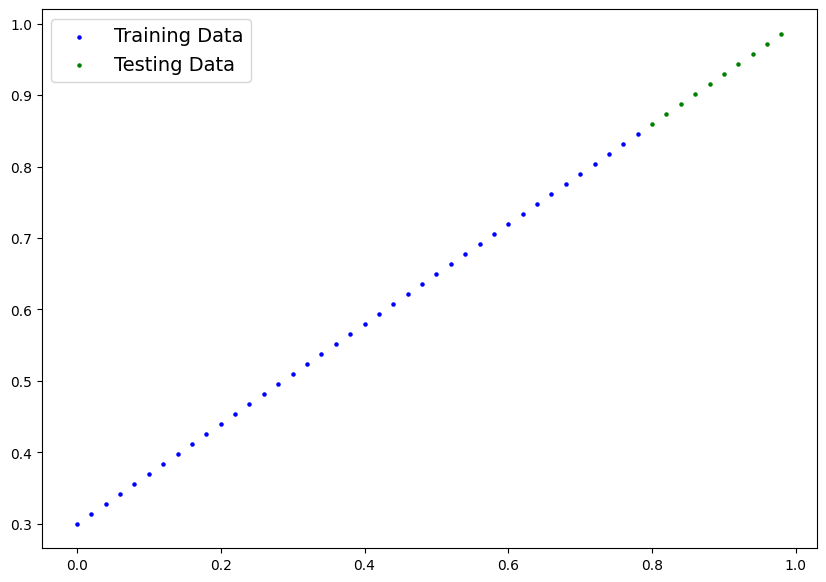

In [ ]:
plot_predictions()

## 2. Build Model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything.

Let's replicate a standard linear regression model using pure PyTorch.

`Resource:` We'll be using Python classes to create bits and pieces for building neural networks. If you're unfamiliar with Python class notation, I'd recommend reading https://realpython.com/python3-object-oriented-programming/ guide a few times.

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


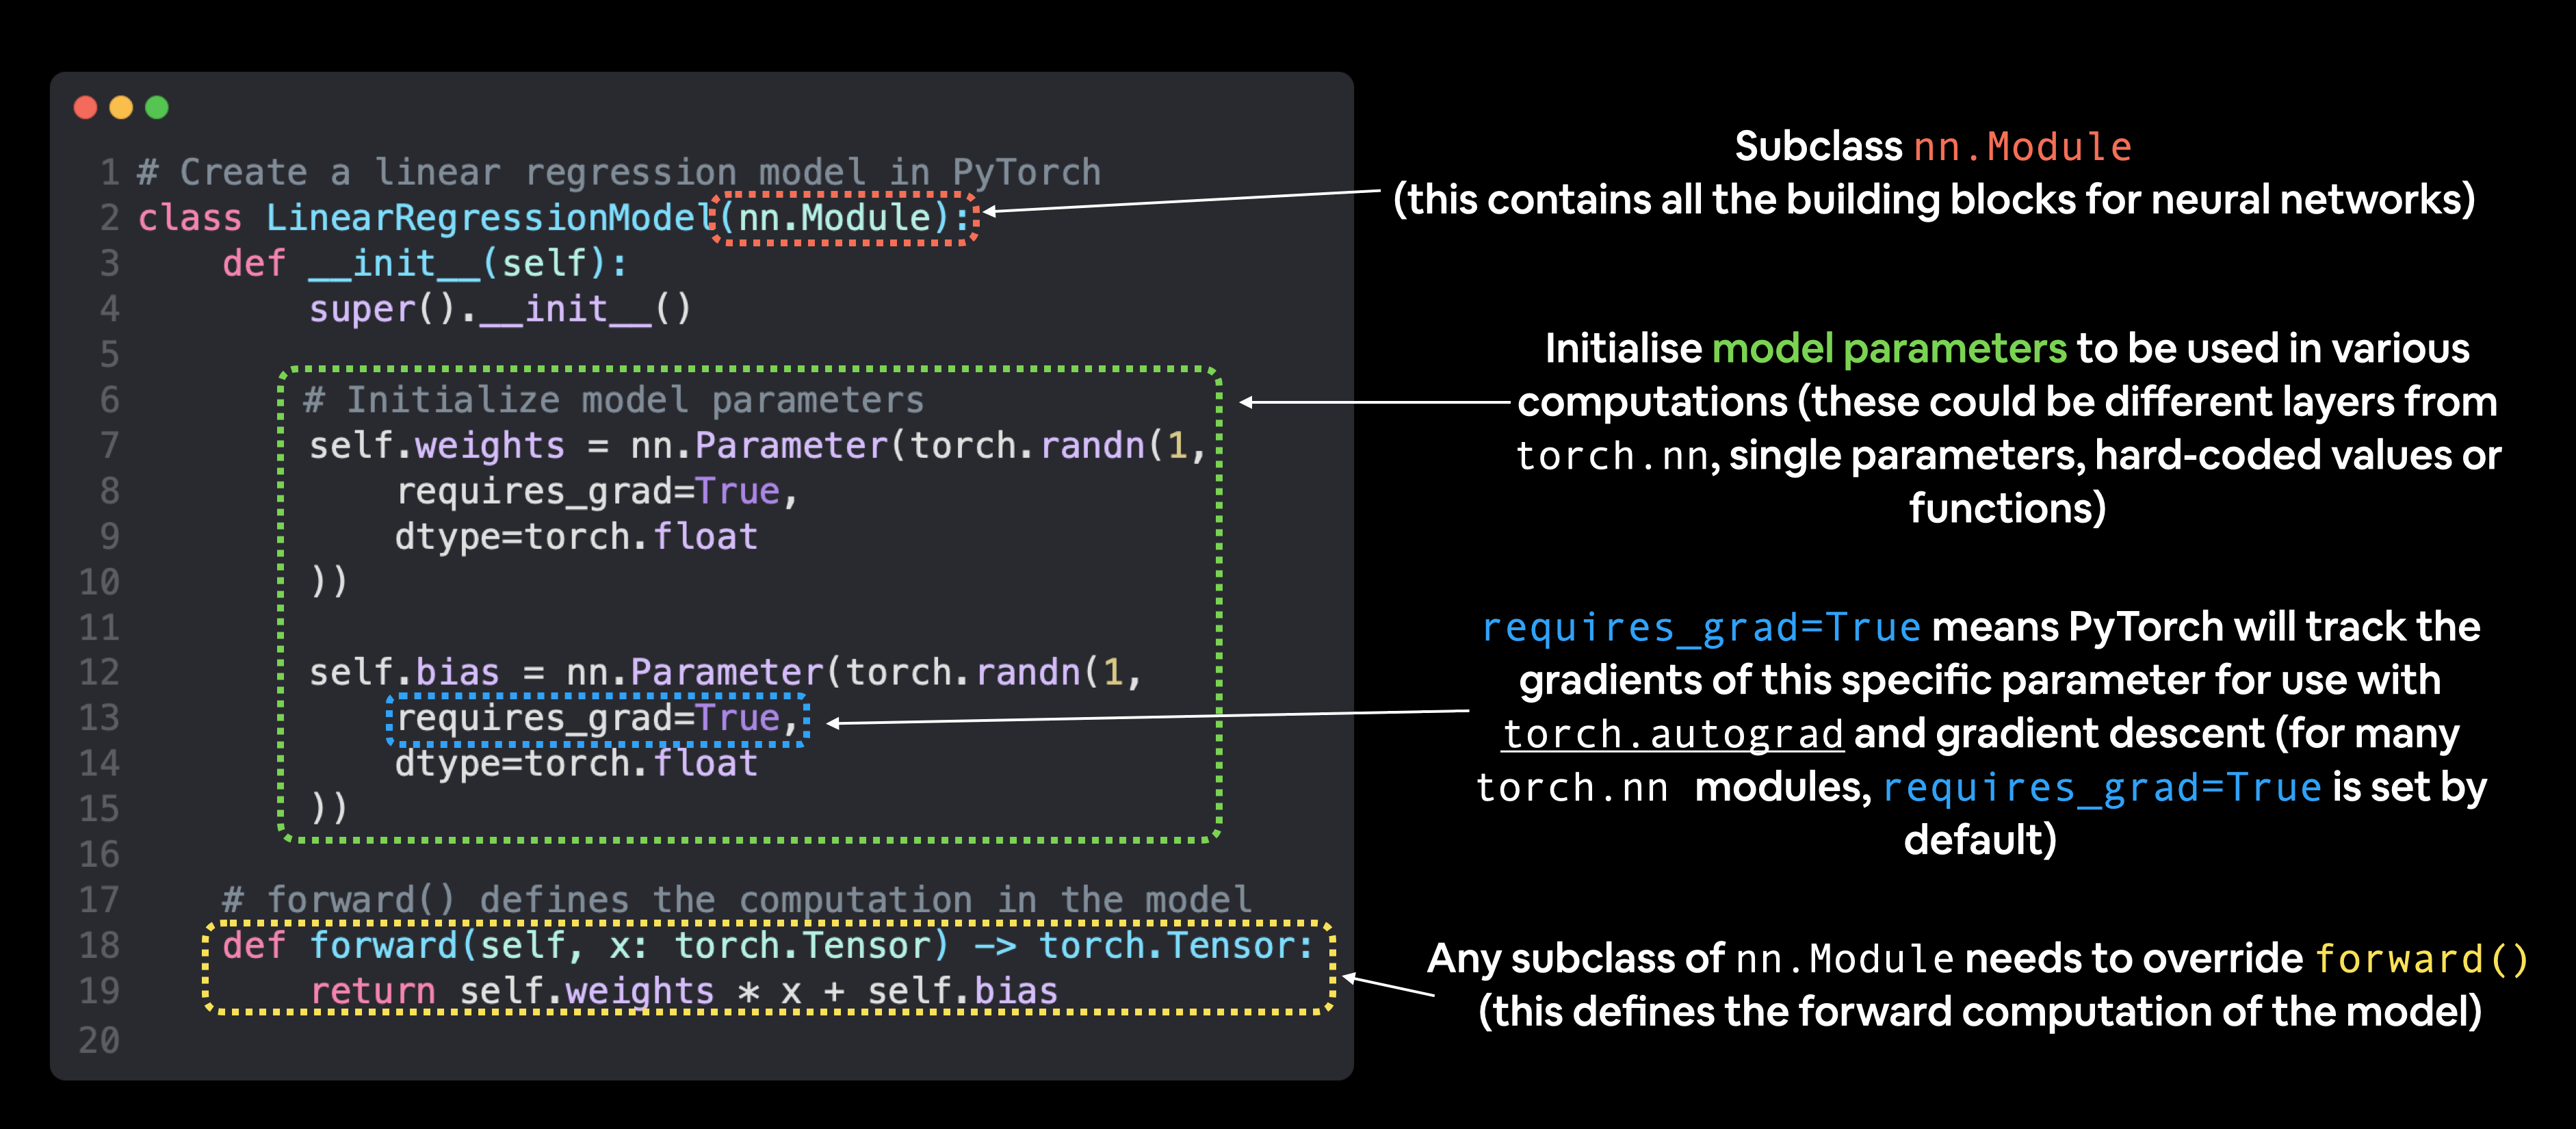

## PyTorch model building essentials
 - `torch.nn` - containes all the buildings for computational graphs
 - `torch.nn.Paramater` - what parameters should our model try and learn, often a PyTorch layer from
 torch.nn will set these for us.
 - `torch.nn.Module` - The base class for all neural network modules, if you subclassit, you should
 overwrite forward().
 - `torch.optim` - this where the optimizers in PyTorch live, they will help in gradient descent.
 - `def forward()` - All nn.Module subclasses require you to overwrite forward(), this method defines
 what happens in the forward computation.

Resource: https://www.learnpytorch.io/01_pytorch_workflow/#pytorch-model-building-essentials


## Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside.

So we can check our model parameters or what's inside our model using `.parameters()`

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

### Making predictions using `torch.inference_mode()`

To check this we can pass it the test data `X_test` to see how closely it predicts `y_test`.

When we pass data to our model, it'll go through the model's `forward()` method and produce a result using the computation we've defined.

In [ ]:
# Make predictions with model
with torch.inference_mode(): # This helps in not keeping the track of gradients
  y_preds = model_0(X_test)


y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

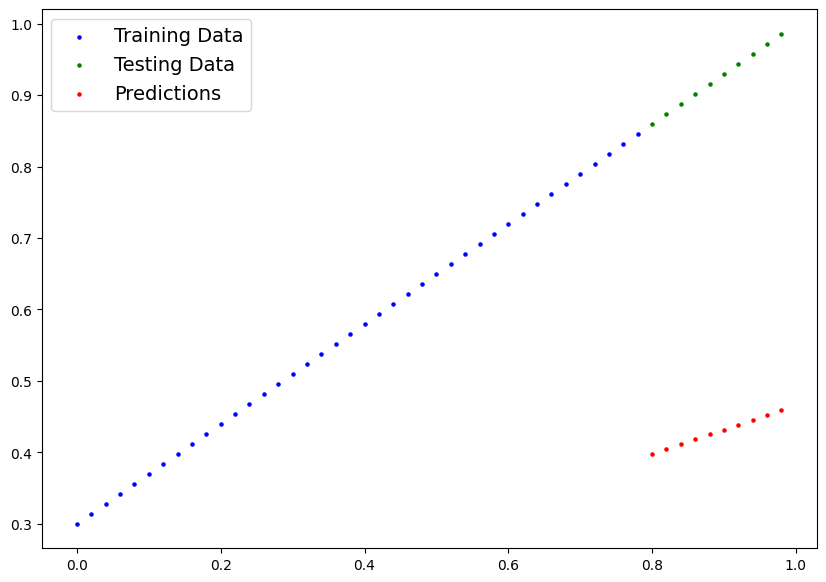

In [ ]:
plot_predictions(predictions=y_preds)

## 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the `weights` and `bias` values we set randomly using `nn.Parameter()` and `torch.randn()` to be something that better represents the data.

We could hard code this (since we know the default values `weight=0.7` and `bias=0.3`) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.

Things we need to train:

 - __Loss Function__: A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.

 - __Optimizer__: Takes into accout the loss of a model and adjusts the model's parameters (e.g. weights and bias in our case) to improve loss function.

And we'll use SGD, `torch.optim.SGD`(params, lr) where:

`params` is the target model parameters you'd like to optimize (e.g. the `weights` and `bias` values we randomly set before).
`lr` is the `learning rate` you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a `hyperparameter` (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).


And specifically for PyTorch, we need,

 - A training loop
 - A testing loop

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Creating an optimization loop in PyTorch

Woohoo! Now we've got a loss function and an optimizer, it's now time to create a training loop (and testing loop).

The training loop involves the model going through the training data and learning the relationships between the `features` and `labels`.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

In [ ]:
model_0.eval()

LinearRegressionModel()

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data
epochs = 200

#Track different values
epoch_count =[]
loss_values = []
test_loss_values = []


# 0.Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # Train mode in PyTorch sets all parameters that require gradients

# 1.Forward pass
  y_pred = model_0(X_train)

# 2.Calculate the loss
  loss = loss_fn(y_pred, y_train)
  #print(f"Loss: {loss}")

# 3.Optimizer zero grad
  optimizer.zero_grad()

# 4.Perform backpropagation on the loss with respect to teh paramaters of the model
  loss.backward()

# 5.Step the optimizer (perform gradient descent)
  optimizer.step()

### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing
  with torch.inference_mode(): # Turns of gradient tracking
    # 1. Do the forward pass
    test_predictions = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_predictions, y_test)

  # print out what happened

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    ### Print model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

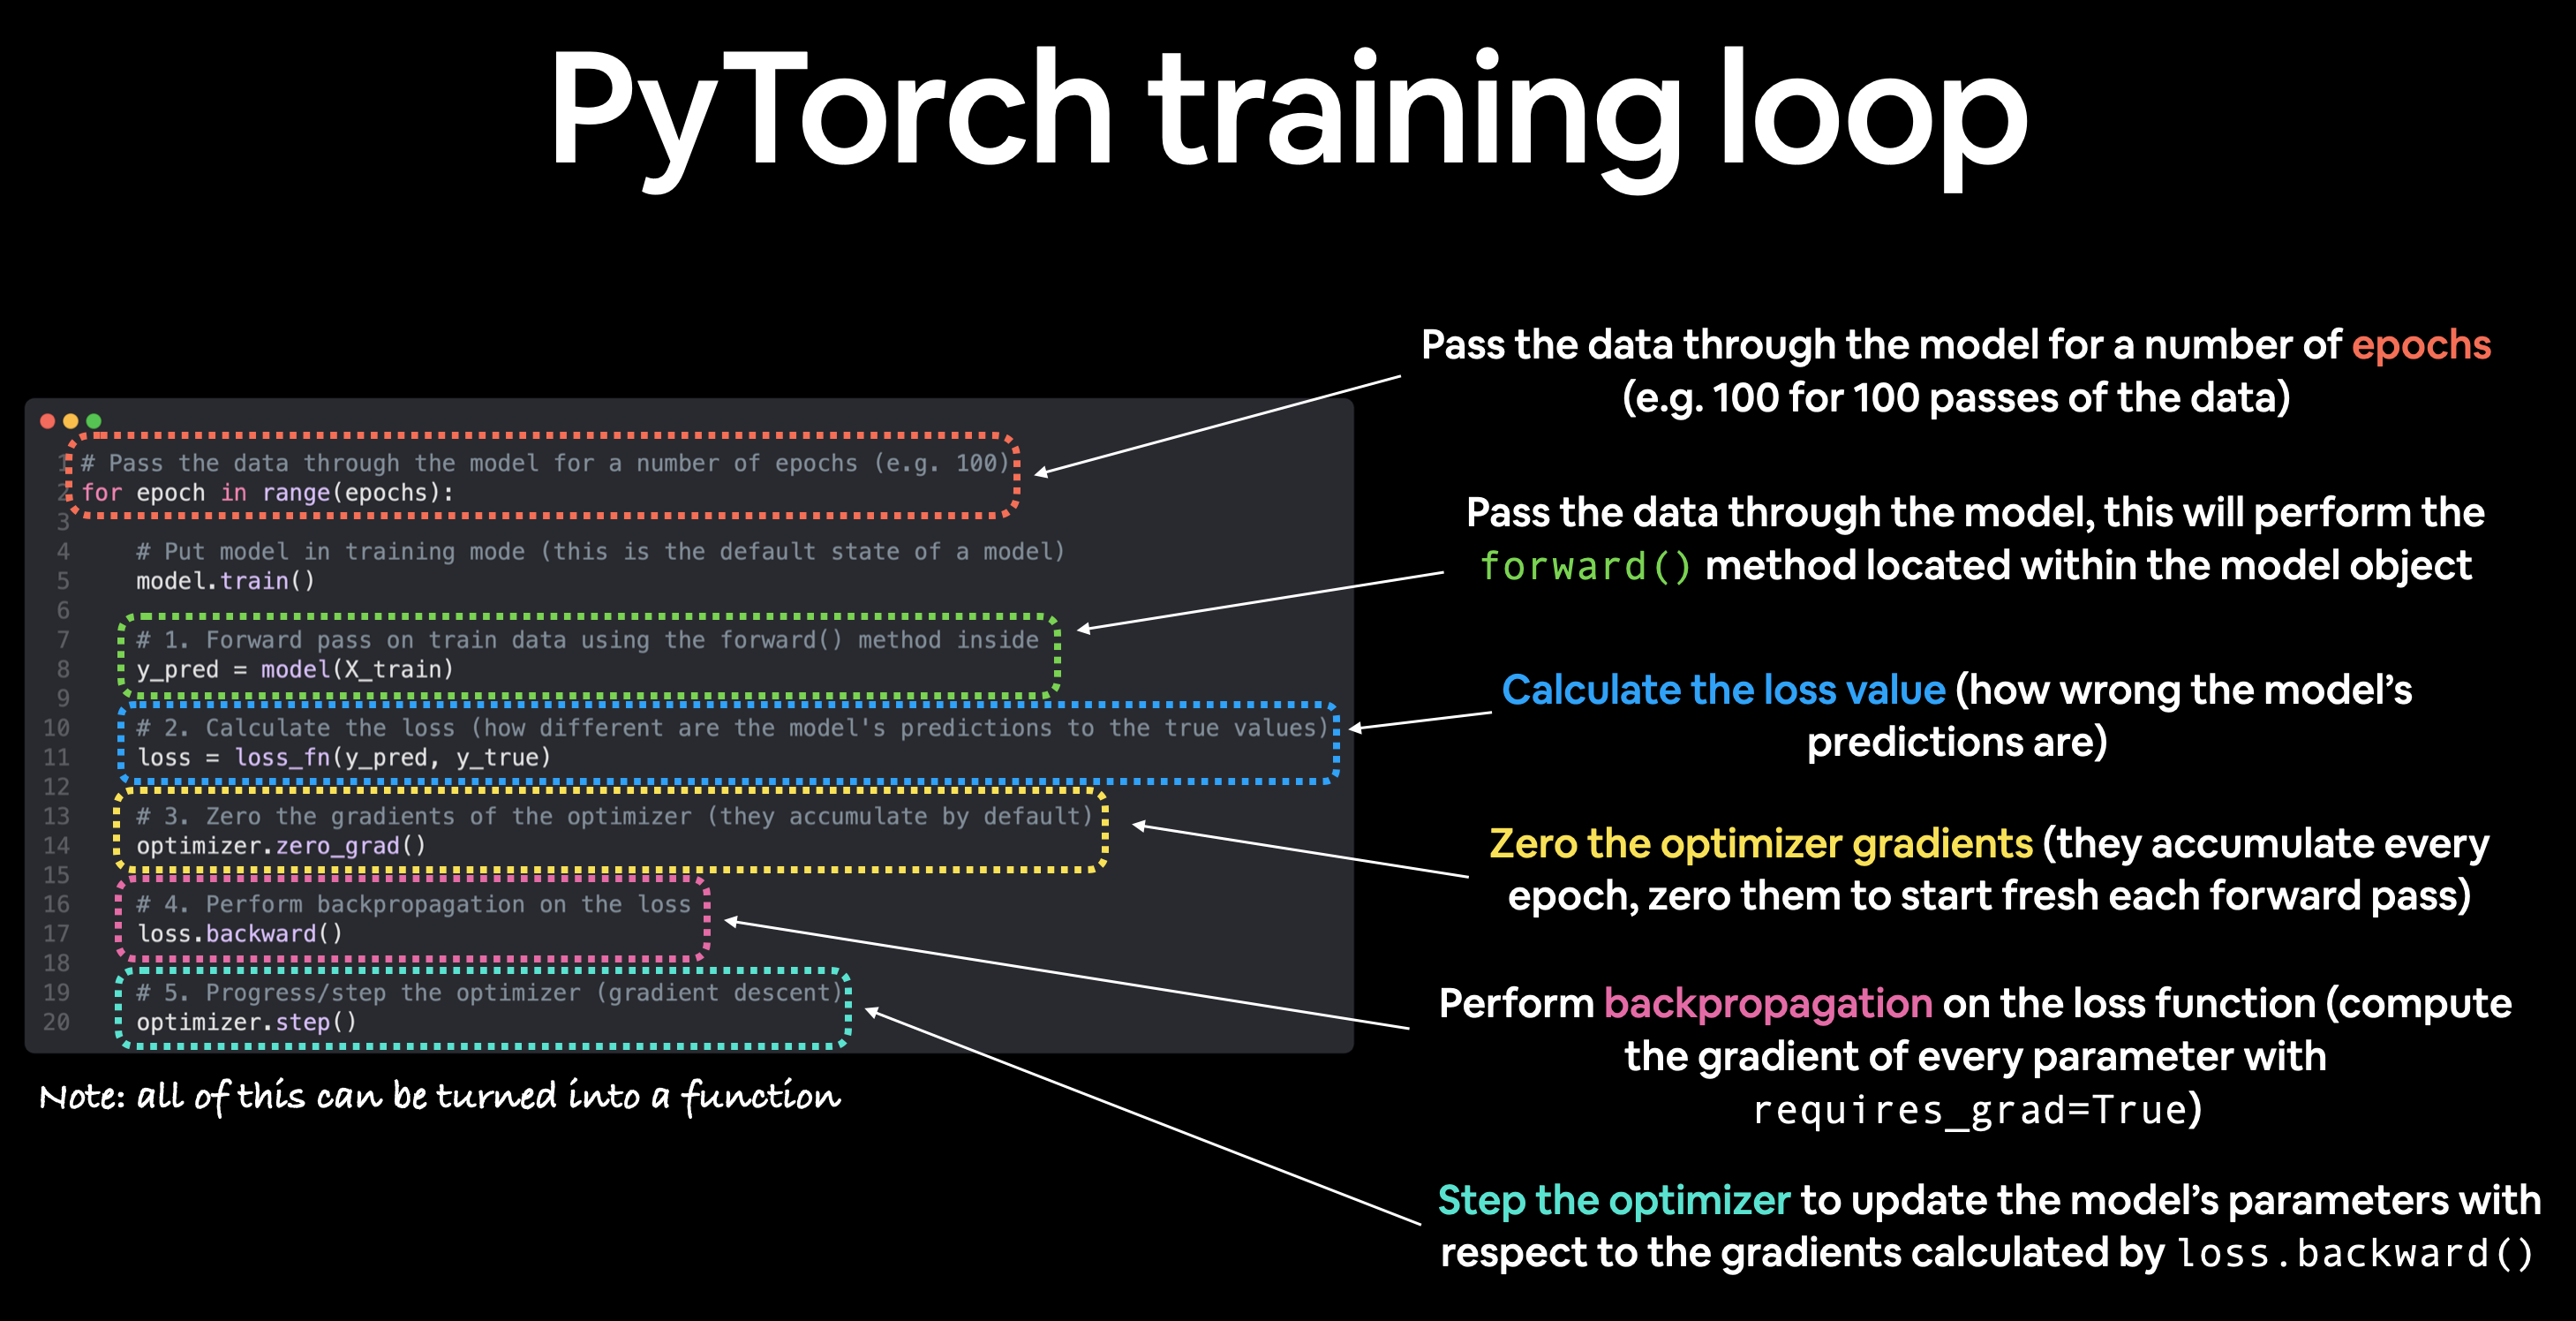

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
with torch.inference_mode():
  y_pred_new = model_0(X_test)

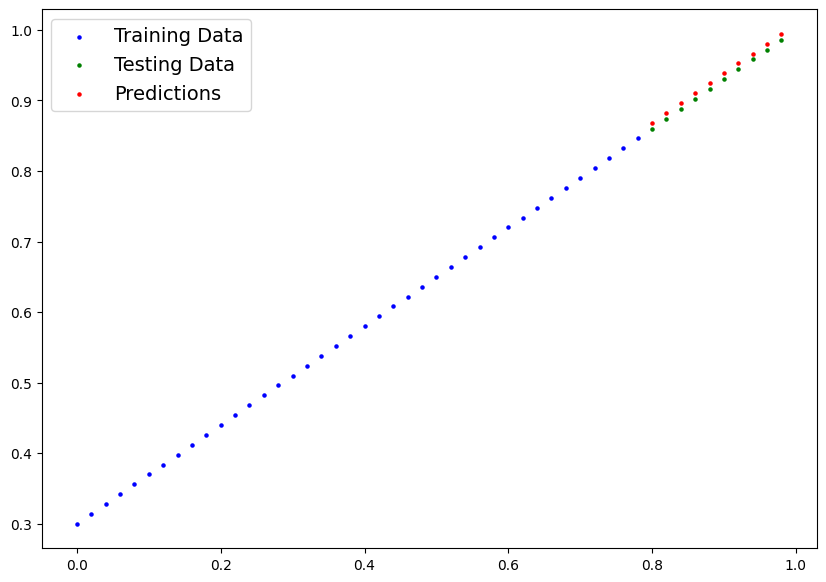

In [ ]:
plot_predictions(predictions=y_pred_new)

In [ ]:
loss_values

[tensor(0.3129, grad_fn=<MeanBackward0>),
 tensor(0.1977, grad_fn=<MeanBackward0>),
 tensor(0.0891, grad_fn=<MeanBackward0>),
 tensor(0.0531, grad_fn=<MeanBackward0>),
 tensor(0.0454, grad_fn=<MeanBackward0>),
 tensor(0.0417, grad_fn=<MeanBackward0>),
 tensor(0.0382, grad_fn=<MeanBackward0>),
 tensor(0.0348, grad_fn=<MeanBackward0>),
 tensor(0.0313, grad_fn=<MeanBackward0>),
 tensor(0.0279, grad_fn=<MeanBackward0>),
 tensor(0.0245, grad_fn=<MeanBackward0>),
 tensor(0.0210, grad_fn=<MeanBackward0>),
 tensor(0.0176, grad_fn=<MeanBackward0>),
 tensor(0.0142, grad_fn=<MeanBackward0>),
 tensor(0.0107, grad_fn=<MeanBackward0>),
 tensor(0.0073, grad_fn=<MeanBackward0>),
 tensor(0.0039, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>),
 tensor(0.0089, grad_fn=<MeanBackward0>)]

In [ ]:
np.array(torch.tensor(loss_values).numpy())

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

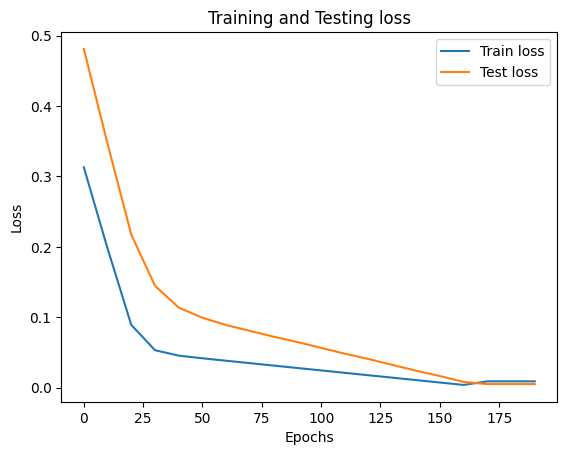

In [ ]:
import numpy as np

# Plot the curves

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title("Training and Testing loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend( )

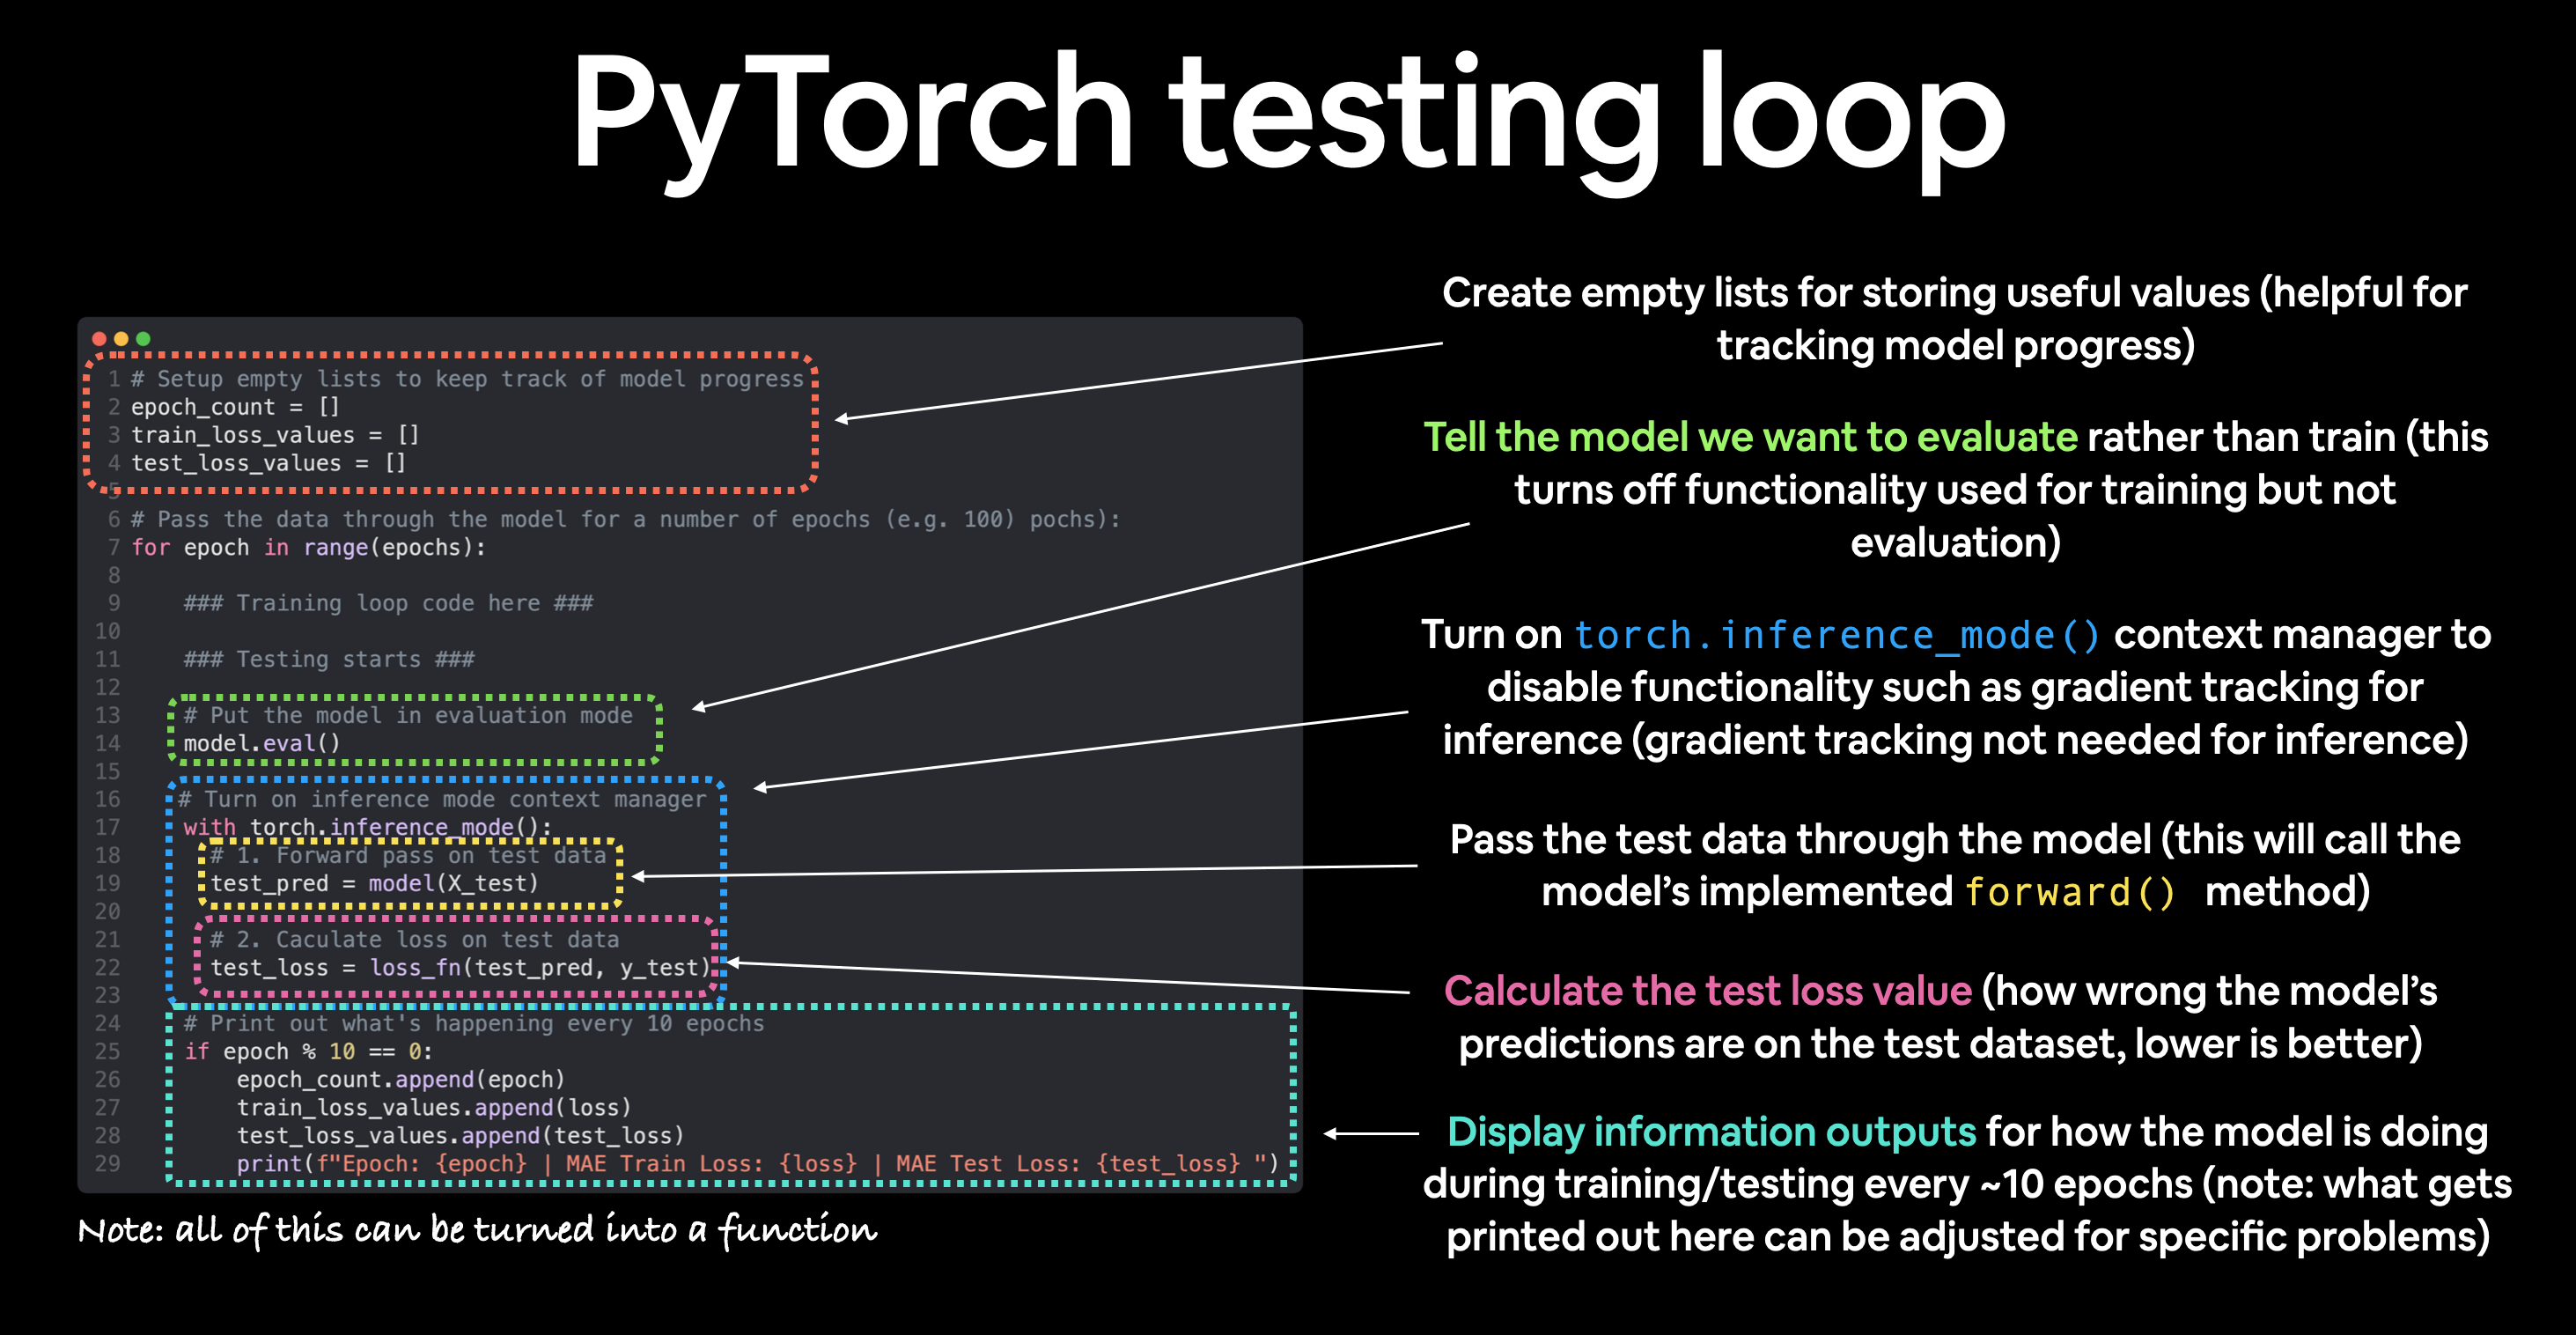

## Saving the Model in PyTorch

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

__For saving and loading models in PyTorch, there are three main methods you should be aware of__ https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference

`torch.save`:
	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.

`torch.load`:
	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).

`torch.nn.Module.load_state_dict`:
	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [ ]:
# Saving our pytorch model
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("practice_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create Model save path
MODEL_NAME = "01_Practice_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save model in state_dict()
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

## Loading our pytorch model

Since we've now got a saved model `state_dict()` at `models/01_pytorch_workflow_model_0.pth` we can now load it in using `torch.nn.Module.load_state_dict(torch.load(f))` where `f` is the filepath of our saved model `state_dict()`.

In [ ]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict() of model_0
loaded_model_0.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# Make some predictions with our model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Compare loaded model preds with the orifinal pred
y_preds == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

In [ ]:
# First make some model preds
model_0.eval()
with torch.inference_mode():
  y_pred = model_0(X_test)

y_pred

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [ ]:
# Now compare again..
y_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])